Solve NS for flow around a cylinder (x,y,t) = [-L/2 L/2] * [-L/2 L/2] * (0,1)

L = 0.01 m

$IC : u,v = 0$

$BC : \frac{\partial \psi^*}{\partial y^*}(-1,y^*) = 1$; $\frac{\partial \psi^*}{\partial x^*}(x^*,\pm 1) = 0$;


incompressible Newtonian 2D momentum and mass conservation condensed into one equation:

$\frac{\partial \bigtriangledown^{*2} \psi^* }{\partial t^*} + \frac{\partial \bigtriangledown^{*2} \psi^* }{\partial x^*} \frac{\partial \psi^* }{\partial y^*} - \frac{\partial \bigtriangledown^{*2} \psi^* }{\partial y^*} \frac{\partial \psi^* }{\partial x^*} = \frac{1}{Re} \bigtriangledown^{*4} \psi^*$

Recommended algorithm: https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/blob/main/PINNs/5_BurgersEquation.ipynb

Similar code with deepxde: https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Kovasznay_flow.py

Similar code for flow around cylinder : https://github.com/Shengfeng233/PINN-for-NS-equation/blob/sparse_data/pinn_model.py#L391

Equations:https://en.wikipedia.org/wiki/Non-dimensionalization_and_scaling_of_the_Navier%E2%80%93Stokes_equations

Consequently, much effort has been expended to eliminate the pressure from all or part of the computational process. The stream function formulation eliminates the pressure but only in two dimensions and at the expense of introducing higher derivatives and elimination of the velocity, which is the primary variable of interest.





In [ ]:
# import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import pandas as pd
import random as random
# from pyDOE import lhs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Parameters
L = 0.01
U = 0.01
Re = 100

In [ ]:
a = torch.tensor(2.35575)
b = a.to(torch.float32)
print("%.6f" % b)


2.355750


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is: ', device)
#torch.set_default_tensor_type(torch.DoubleTensor)

device is:  cuda:0


In [ ]:
seed = 100

In [ ]:
torch.manual_seed(seed)
class PINN_Net(nn.Module):
    def __init__(self, layer_mat):
        torch.manual_seed(seed)
        super(PINN_Net, self).__init__()
        self.layer_num = len(layer_mat) - 1
        self.base = nn.Sequential()
        for i in range(0, self.layer_num - 1):
            self.base.add_module(str(i) + "linear", nn.Linear(layer_mat[i], layer_mat[i + 1]))
            # nn.init.kaiming_normal()
            self.base.add_module(str(i) + "Activation", nn.Tanh())
        self.base.add_module(str(self.layer_num - 1) + "linear",
                             nn.Linear(layer_mat[self.layer_num - 1], layer_mat[self.layer_num]))
        # self.lam1 = nn.Parameter(torch.randn(1, requires_grad=True))
        # self.lam2 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.Initial_param()
        # self.double()

    def forward(self, x, y, t):
        X = torch.cat([x, y, t], 1).requires_grad_(True)
        predict = self.base(X)  #predict = psi#
        return predict

    def Initial_param(self):
        for name, param in self.base.named_parameters():
            if name.endswith('weight'):
                nn.init.xavier_normal_(param)
            elif name.endswith('bias'):
                nn.init.zeros_(param)

    def loss_reference(self, x_sens, y_sens, t_sens, u_sens, v_sens):
        predict_out = self.forward(x_sens, y_sens, t_sens)
        psi = predict_out[:, 0].reshape(-1, 1)
        u_predict = torch.autograd.grad(psi.sum(), y_sens, create_graph=True, retain_graph=True)[0]
        v_predict = -torch.autograd.grad(psi.sum(), x_sens, create_graph=True, retain_graph=True)[0]
        mse = torch.nn.MSELoss()
        mse_predict = mse(u_predict, u_sens) + mse(v_predict, v_sens)
        return mse_predict


    def BC_loss_velocity(self, x, y, t, u, v):
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        u_predict = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v_predict = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
        mse = torch.nn.MSELoss()
        mse_predict = mse(u_predict, u) + mse(v_predict, v)
        return mse_predict



    def PDE_loss(self, x, y, t, Re):
        # print('begin of PDE_loss')
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        # p = predict_out[:, 1].reshape(-1, 1)
        psi_x = torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
        psi_y = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        psi_xx = torch.autograd.grad(psi_x.sum(), x, create_graph=True, retain_graph=True)[0]
        psi_xxx = torch.autograd.grad(psi_xx.sum(), x, create_graph=True, retain_graph=True)[0]
        psi_xxxx = torch.autograd.grad(psi_xxx.sum(), x, create_graph=True, retain_graph=True)[0]
        psi_yy = torch.autograd.grad(psi_y.sum(), y, create_graph=True, retain_graph=True)[0]
        psi_yyy = torch.autograd.grad(psi_yy.sum(), y, create_graph=True, retain_graph=True)[0]
        psi_yyyy = torch.autograd.grad(psi_yyy.sum(), y, create_graph=True, retain_graph=True)[0]
        psi_xxy = torch.autograd.grad(psi_xx.sum(), y, create_graph=True, retain_graph=True)[0]
        psi_xxyy = torch.autograd.grad(psi_xxy.sum(), y, create_graph=True, retain_graph=True)[0]
        Laplacian_psi = psi_xx + psi_yy
        dLaplacian_dt = torch.autograd.grad(Laplacian_psi.sum(), t, create_graph=True, retain_graph=True)[0]
        dLaplacian_dx = torch.autograd.grad(Laplacian_psi.sum(), x, create_graph=True, retain_graph=True)[0]
        dLaplacian_dy = torch.autograd.grad(Laplacian_psi.sum(), y, create_graph=True, retain_graph=True)[0]

        f_equation = dLaplacian_dt + dLaplacian_dx*psi_y - dLaplacian_dy*psi_x - (1/Re)*(psi_xxxx + psi_yyyy + 2*psi_xxyy)
        mse = torch.nn.MSELoss()
        batch_t_zeros = torch.from_numpy(np.zeros((x.shape[0], 1))).float().requires_grad_(True).to(device)
        mse_equation =  mse(f_equation, batch_t_zeros)

        return mse_equation

    def total_loss(self, x_bc, y_bc, t_bc, u_bc, v_bc, x_sens, y_sens, t_sens, u_sens, v_sens):
         output = self.BC_loss_velocity(x_bc, y_bc, t_bc, u_bc, v_bc) + self.PDE_loss(x_bc, y_bc, t_bc, Re) + self.PDE_loss(x_sens, y_sens, t_sens, Re) + self.loss_reference(x_sens,y_sens,t_sens,u_sens,v_sens)
         #print('loss type: ', output.dtype)
         return output
        #  return output.double()



    def inference(self, x, y, t):
        # predict_out = self.forward(x, y, t)
        # psi = predict_out[:, 0].reshape(-1, 1)
        # p = predict_out[:, 1].reshape(-1, 1)
        # u = torch.autograd.grad(psi.sum(), y)[0]
        # v = -torch.autograd.grad(psi.sum(), x)[0]

        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        u = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]

        return u,v

In [ ]:
u_sens_df = pd.read_csv('/content/scaledU.csv')
v_sens_df = pd.read_csv('/content/scaledV.csv')
t_list = []
for i in range(101):
    t_list.append(i/100)

In [ ]:
random.seed(0)
x_sens = torch.tensor(u_sens_df['x'],dtype = torch.float64)
y_sens = torch.tensor(u_sens_df['y'],dtype = torch.float64)
t_sens = torch.tensor(t_list,dtype = torch.float64)
random_rows = random.sample(range(len(x_sens)),100)
random_columns = random.sample(range(len(t_sens)),10)
x_sens_f = x_sens[random_rows]
y_sens_f = y_sens[random_rows]
t_sens_f = t_sens[random_columns].requires_grad_(True).to(device).to(torch.float64)

In [ ]:
x_sens_f

In [ ]:
x_sens_ff = torch.repeat_interleave(x_sens_f, 10).unsqueeze(-1).requires_grad_(True).to(device)
y_sens_ff = torch.repeat_interleave(y_sens_f, 10).unsqueeze(-1).requires_grad_(True).to(device)
t_sens_ff = torch.repeat_interleave(t_sens_f, 100).unsqueeze(-1).requires_grad_(True).to(device)
u_sens = torch.empty_like(x_sens_ff)
v_sens = torch.empty_like(x_sens_ff)

for i in range(len(x_sens_ff)):
    #print(i)
    filtered_row_u = u_sens_df[(u_sens_df['x'] == x_sens_ff[i].item()) & (u_sens_df['y'] == y_sens_ff[i].item())]
    filtered_row_v = v_sens_df[(v_sens_df['x'] == x_sens_ff[i].item()) & (v_sens_df['y'] == y_sens_ff[i].item())]
    t_index = np.where(np.array(t_list) == t_sens_ff[i].item())[0][0] + 2
    if (len(filtered_row_u) != len(filtered_row_v)):
      print("keer koloft")
      break
    elif (len(filtered_row_u)==1):
        u = filtered_row_u.iloc[:, [t_index]].iloc[0][0]
        v = filtered_row_v.iloc[:, [t_index]].iloc[0][0]
        u_sens[i] = u
        v_sens[i] = v

u_sens = u_sens.to(device)
v_sens = v_sens.to(device)

x_sens_ff = x_sens_ff / (L/2)
y_sens_ff = y_sens_ff / (L/2)

In [ ]:
x_sens_ff.shape

torch.Size([1000, 1])

In [ ]:
x_min, y_min, x_max, y_max = -1, -1, +1, +1
t_min, t_max = 0,1
total_points = 100
#time_steps = 0.01

In [ ]:
x_leftbc = -1*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)
y_leftbc = torch.linspace(y_min,y_max,total_points).requires_grad_(True).to(device).to(torch.float64)

x_upperbc = torch.linspace(x_min,x_max,total_points).requires_grad_(True).to(device).to(torch.float64)
y_upperbc = +1*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)

x_lowerbc = torch.linspace(x_min,x_max,total_points).requires_grad_(True).to(device).to(torch.float64)
y_lowerbc = -1*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)

u_leftbc = torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)
v_leftbc = 0*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)

u_upperbc = 0*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)
v_upperbc = 0*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)

u_lowerbc = 0*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)
v_lowerbc = 0*torch.ones(total_points).requires_grad_(True).to(device).to(torch.float64)

#t_bc = torch.linspace(t_min,t_max,time_steps).requires_grad_(True)


In [ ]:
x_leftbc.to(torch.float64).dtype

torch.float64

In [ ]:
x_leftbc, t_leftbc = torch.meshgrid(x_leftbc, t_sens_ff.squeeze())
y_leftbc, t_leftbc = torch.meshgrid(y_leftbc, t_sens_ff.squeeze())
u_leftbc, t_leftbc= torch.meshgrid(u_leftbc, t_sens_ff.squeeze())
v_leftbc, t_leftbc= torch.meshgrid(v_leftbc, t_sens_ff.squeeze())

x_leftbc = torch.reshape(x_leftbc, (-1, 1))
y_leftbc = torch.reshape(y_leftbc, (-1, 1))
t_leftbc = torch.reshape(t_leftbc, (-1, 1))
u_leftbc = torch.reshape(u_leftbc, (-1, 1))
v_leftbc = torch.reshape(v_leftbc, (-1, 1))

#x_leftbc.shape , y_leftbc.shape, t_sens_ff.shape, u_leftbc.shape, v_leftbc.shape


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print( t_leftbc.shape)

torch.Size([60000, 1])


In [ ]:
x_upperbc, t_upperbc = torch.meshgrid(x_upperbc, t_sens_ff.squeeze())
y_upperbc, t_upperbc = torch.meshgrid(y_upperbc, t_sens_ff.squeeze())
u_upperbc, t_upperbc = torch.meshgrid(u_upperbc, t_sens_ff.squeeze())
v_upperbc, t_upperbc = torch.meshgrid(v_upperbc, t_sens_ff.squeeze())

x_upperbc = torch.reshape(x_upperbc, (-1, 1))
y_upperbc = torch.reshape(y_upperbc, (-1, 1))
t_upperbc = torch.reshape(t_upperbc, (-1, 1))
u_upperbc = torch.reshape(u_upperbc, (-1, 1))
v_upperbc = torch.reshape(v_upperbc, (-1, 1))

x_upperbc.shape , y_upperbc.shape, t_upperbc.shape, u_upperbc.shape, v_upperbc.shape

(torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]))

In [ ]:
x_lowerbc, t_lowerbc = torch.meshgrid(x_lowerbc, t_sens_ff.squeeze())
y_lowerbc, t_lowerbc = torch.meshgrid(y_lowerbc, t_sens_ff.squeeze())
u_lowerbc, t_lowerbc = torch.meshgrid(u_lowerbc, t_sens_ff.squeeze())
v_lowerbc, t_lowerbc = torch.meshgrid(v_lowerbc, t_sens_ff.squeeze())

x_lowerbc = torch.reshape(x_lowerbc, (-1, 1))
y_lowerbc = torch.reshape(y_lowerbc, (-1, 1))
t_lowerbc = torch.reshape(t_lowerbc, (-1, 1))
u_lowerbc = torch.reshape(u_lowerbc, (-1, 1))
v_lowerbc = torch.reshape(v_lowerbc, (-1, 1))

x_lowerbc.shape , y_lowerbc.shape, t_lowerbc.shape, u_lowerbc.shape, v_lowerbc.shape

(torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]),
 torch.Size([100000, 1]))

In [ ]:
x_bc = torch.cat((x_leftbc, x_upperbc, x_lowerbc), dim=0).to(device)
y_bc = torch.cat((y_leftbc, y_upperbc, y_lowerbc), dim=0).to(device)
u_bc = torch.cat((u_leftbc, u_upperbc, u_lowerbc), dim=0).to(device)
v_bc = torch.cat((v_leftbc, v_upperbc, v_lowerbc), dim=0).to(device)
t_bc = torch.cat((t_leftbc, t_upperbc, t_lowerbc), dim=0).to(device)

In [ ]:
x_bc.shape , y_bc.shape , t_bc.shape, u_bc.shape , v_bc.shape

In [ ]:
# Defining interior domain (Total - boundaries)
#.view(-1,1).
#t_collo = torch.linspace(t_min,t_max,time_steps).requires_grad_(True)

x_collo = torch.linspace(x_min+1e-3,x_max-1e-3,total_points).requires_grad_(True).to(device).to(torch.float64)
y_collo = torch.linspace(y_min+1e-3,y_max-1e-3,total_points).requires_grad_(True).to(device).to(torch.float64)

x_collo, y_collo, t_collo = torch.meshgrid(x_collo, y_collo, t_sens_ff.squeeze())
x_collo = torch.reshape(x_collo, (-1, 1)).to(device)
y_collo = torch.reshape(y_collo, (-1, 1)).to(device)
t_collo = torch.reshape(t_collo, (-1, 1)).to(device)

x_collo.shape , y_collo.shape , t_collo.shape

(torch.Size([6000000, 1]), torch.Size([6000000, 1]), torch.Size([6000000, 1]))

In [ ]:
#Network's parameters
torch.manual_seed(seed)

layers = [3, 20, 20, 1]
# lr = 1e-4
# n_epochs = 5000
PINN = PINN_Net(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
# optimizer = torch.optim.Adam(PINN.parameters(),lr=lr)

PINN_Net(
  (base): Sequential(
    (0linear): Linear(in_features=3, out_features=20, bias=True)
    (0Activation): Tanh()
    (1linear): Linear(in_features=20, out_features=20, bias=True)
    (1Activation): Tanh()
    (2linear): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [ ]:
for p in params:
  print(p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [ ]:
# torch.manual_seed(seed)

# loss_list = []
# print("Training Loss-----Test Loss")
# for i in range(n_epochs):
#     print('epoch: ', i+1)
#     loss = PINN.total_loss(x_bc.to(torch.float32), y_bc.to(torch.float32), t_bc.to(torch.float32), u_bc.to(torch.float32),
#                           v_bc.to(torch.float32), x_sens_ff.to(torch.float32), y_sens_ff.to(torch.float32), t_sens_ff.to(torch.float32), u_sens.to(torch.float32), v_sens.to(torch.float32))
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
#     optimizer.step()

#     # if i%(steps/10)==0:
#     #   with torch.no_grad():
#     #     test_loss=PINN.lossBC(x, y, t, u, v)

#     print('train loss :', loss.detach().cpu().numpy())
#     loss_list.append(loss.detach().cpu().numpy())

# plt.plot(loss_list)

In [ ]:
x_bc.to(torch.float64).dtype

In [ ]:
torch.manual_seed(seed)
iter = 0

# Initialize the optimizer
optimizer = torch.optim.LBFGS(PINN.parameters(),
                                lr=1,
                                max_iter=1000,
                                max_eval=10000,
                                history_size=100,
                                tolerance_grad=1e-05,
                                tolerance_change=0.5 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    # x_bc, y_bc, t_bc, u_bc, v_bc = x_bc.to(device), y_bc.to(device), t_bc.to(device), u_bc.to(device), v_bc.to(device)
    # x_collo, y_collo, t_collo = x_collo.to(device), y_collo.to(device), t_collo.to(device)
    # x_rightbc, y_rightbc, t_rightbc, p_rightbc = x_rightbc.to(device), y_rightbc.to(device), t_rightbc.to(device), p_rightbc.to(device)
    loss = PINN.total_loss(x_bc.to(torch.float32), y_bc.to(torch.float32), t_bc.to(torch.float32), u_bc.to(torch.float32),
                           v_bc.to(torch.float32), x_sens_ff.to(torch.float32), y_sens_ff.to(torch.float32), t_sens_ff.to(torch.float32), u_sens.to(torch.float32), v_sens.to(torch.float32))
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    print(f" iteration: {iter}  loss: {loss.item()}")
    return loss




# the optimizer.step requires the closure function to be a callable function without inputs
# therefore we need to define a partial function and pass it to the optimizer
# closure_fn = partial(closure, PINN, optimizer,  x_bc, y_bc, t_bc, u_bc, v_bc, x_collo, y_collo, t_collo, x_rightbc, y_rightbc, t_rightbc, p_rightbc)
optimizer.step(closure)

 iteration: 1  loss: 1.7567765712738037


OutOfMemoryError: ignored

In [ ]:
torch.save(PINN.state_dict(), '/content/drive/My Drive/modified_ns.pth')

In [ ]:
torch.save(PINN.state_dict(), '/content/drive/My Drive/modified_ns.ckpt')

In [ ]:
t_test = torch.linspace(2, 2,1).requires_grad_(True)
x_test = torch.linspace(x_min+1e-3,x_max-1e-3,total_points).requires_grad_(True)
y_test = torch.linspace(y_min+1e-3,y_max-1e-3,total_points).requires_grad_(True)

x_test, y_test, t_test = torch.meshgrid(x_test, y_test, t_test)

x_test = torch.reshape(x_test, (-1, 1)).to(device)
y_test = torch.reshape(y_test, (-1, 1)).to(device)
t_test = torch.reshape(t_test, (-1, 1)).to(device)

x_test.shape, y_test.shape, t_test.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [ ]:
u_test, v_test = PINN.inference(x_test, y_test, t_test)

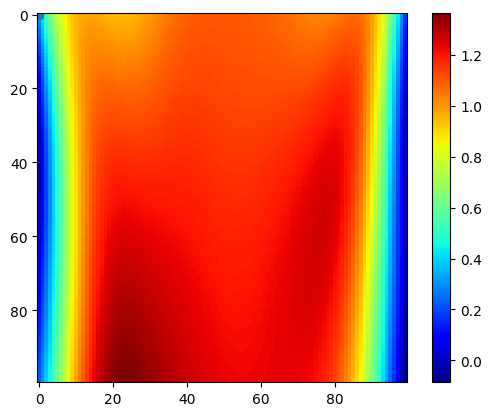

In [ ]:
sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),
            )
plt.imshow(u_test.cpu().detach().numpy().reshape(100,100), cmap='jet')
plt.colorbar()

<ipython-input-43-4f56f17d8b28>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),


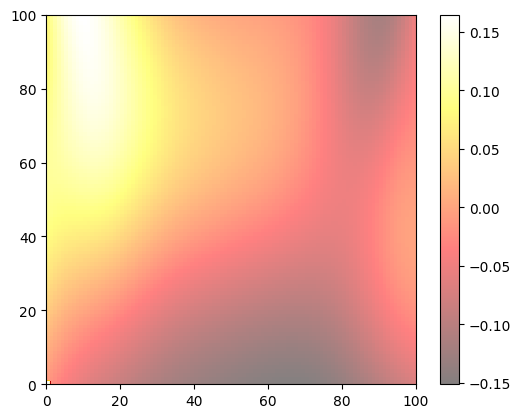

In [ ]:
sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),
            cmap='hot', shade=True)
plt.imshow(v_test.cpu().detach().numpy().reshape(100,100), cmap='hot', alpha=0.5, extent=[0, 100, 0, 100])
plt.colorbar()